In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import itertools
import time

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score, KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix, f1_score, precision_recall_curve, \
make_scorer
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from patsy import dmatrix
from pyearth import Earth

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [4]:
train.columns

Index(['id', 'x001', 'x002', 'x003', 'x004', 'x005', 'x006', 'x007', 'x008',
       'x009',
       ...
       'x757', 'x758', 'x759', 'x760', 'x761', 'x762', 'x763', 'x764', 'x765',
       'y'],
      dtype='object', length=767)

In [5]:
corr_y = train.corrwith(train['y'])
corr_y.abs().sort_values(ascending = False)[0:10]

/var/folders/8n/jcf8jkgd07q33yx5hgq1969r0000gn/T/ipykernel_28847/1354306382.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_y = train.corrwith(train['y'])


y       1.000000
x146    0.378696
x102    0.378436
x014    0.364737
x581    0.346549
x619    0.344101
x687    0.343842
x651    0.329630
x696    0.329630
x755    0.324916
dtype: float64

In [6]:
top_corr = train[['y', 'x146', 'x102', 'x014', 'x581', 'x619', 'x687', 'x651', 'x696', 'x755']]

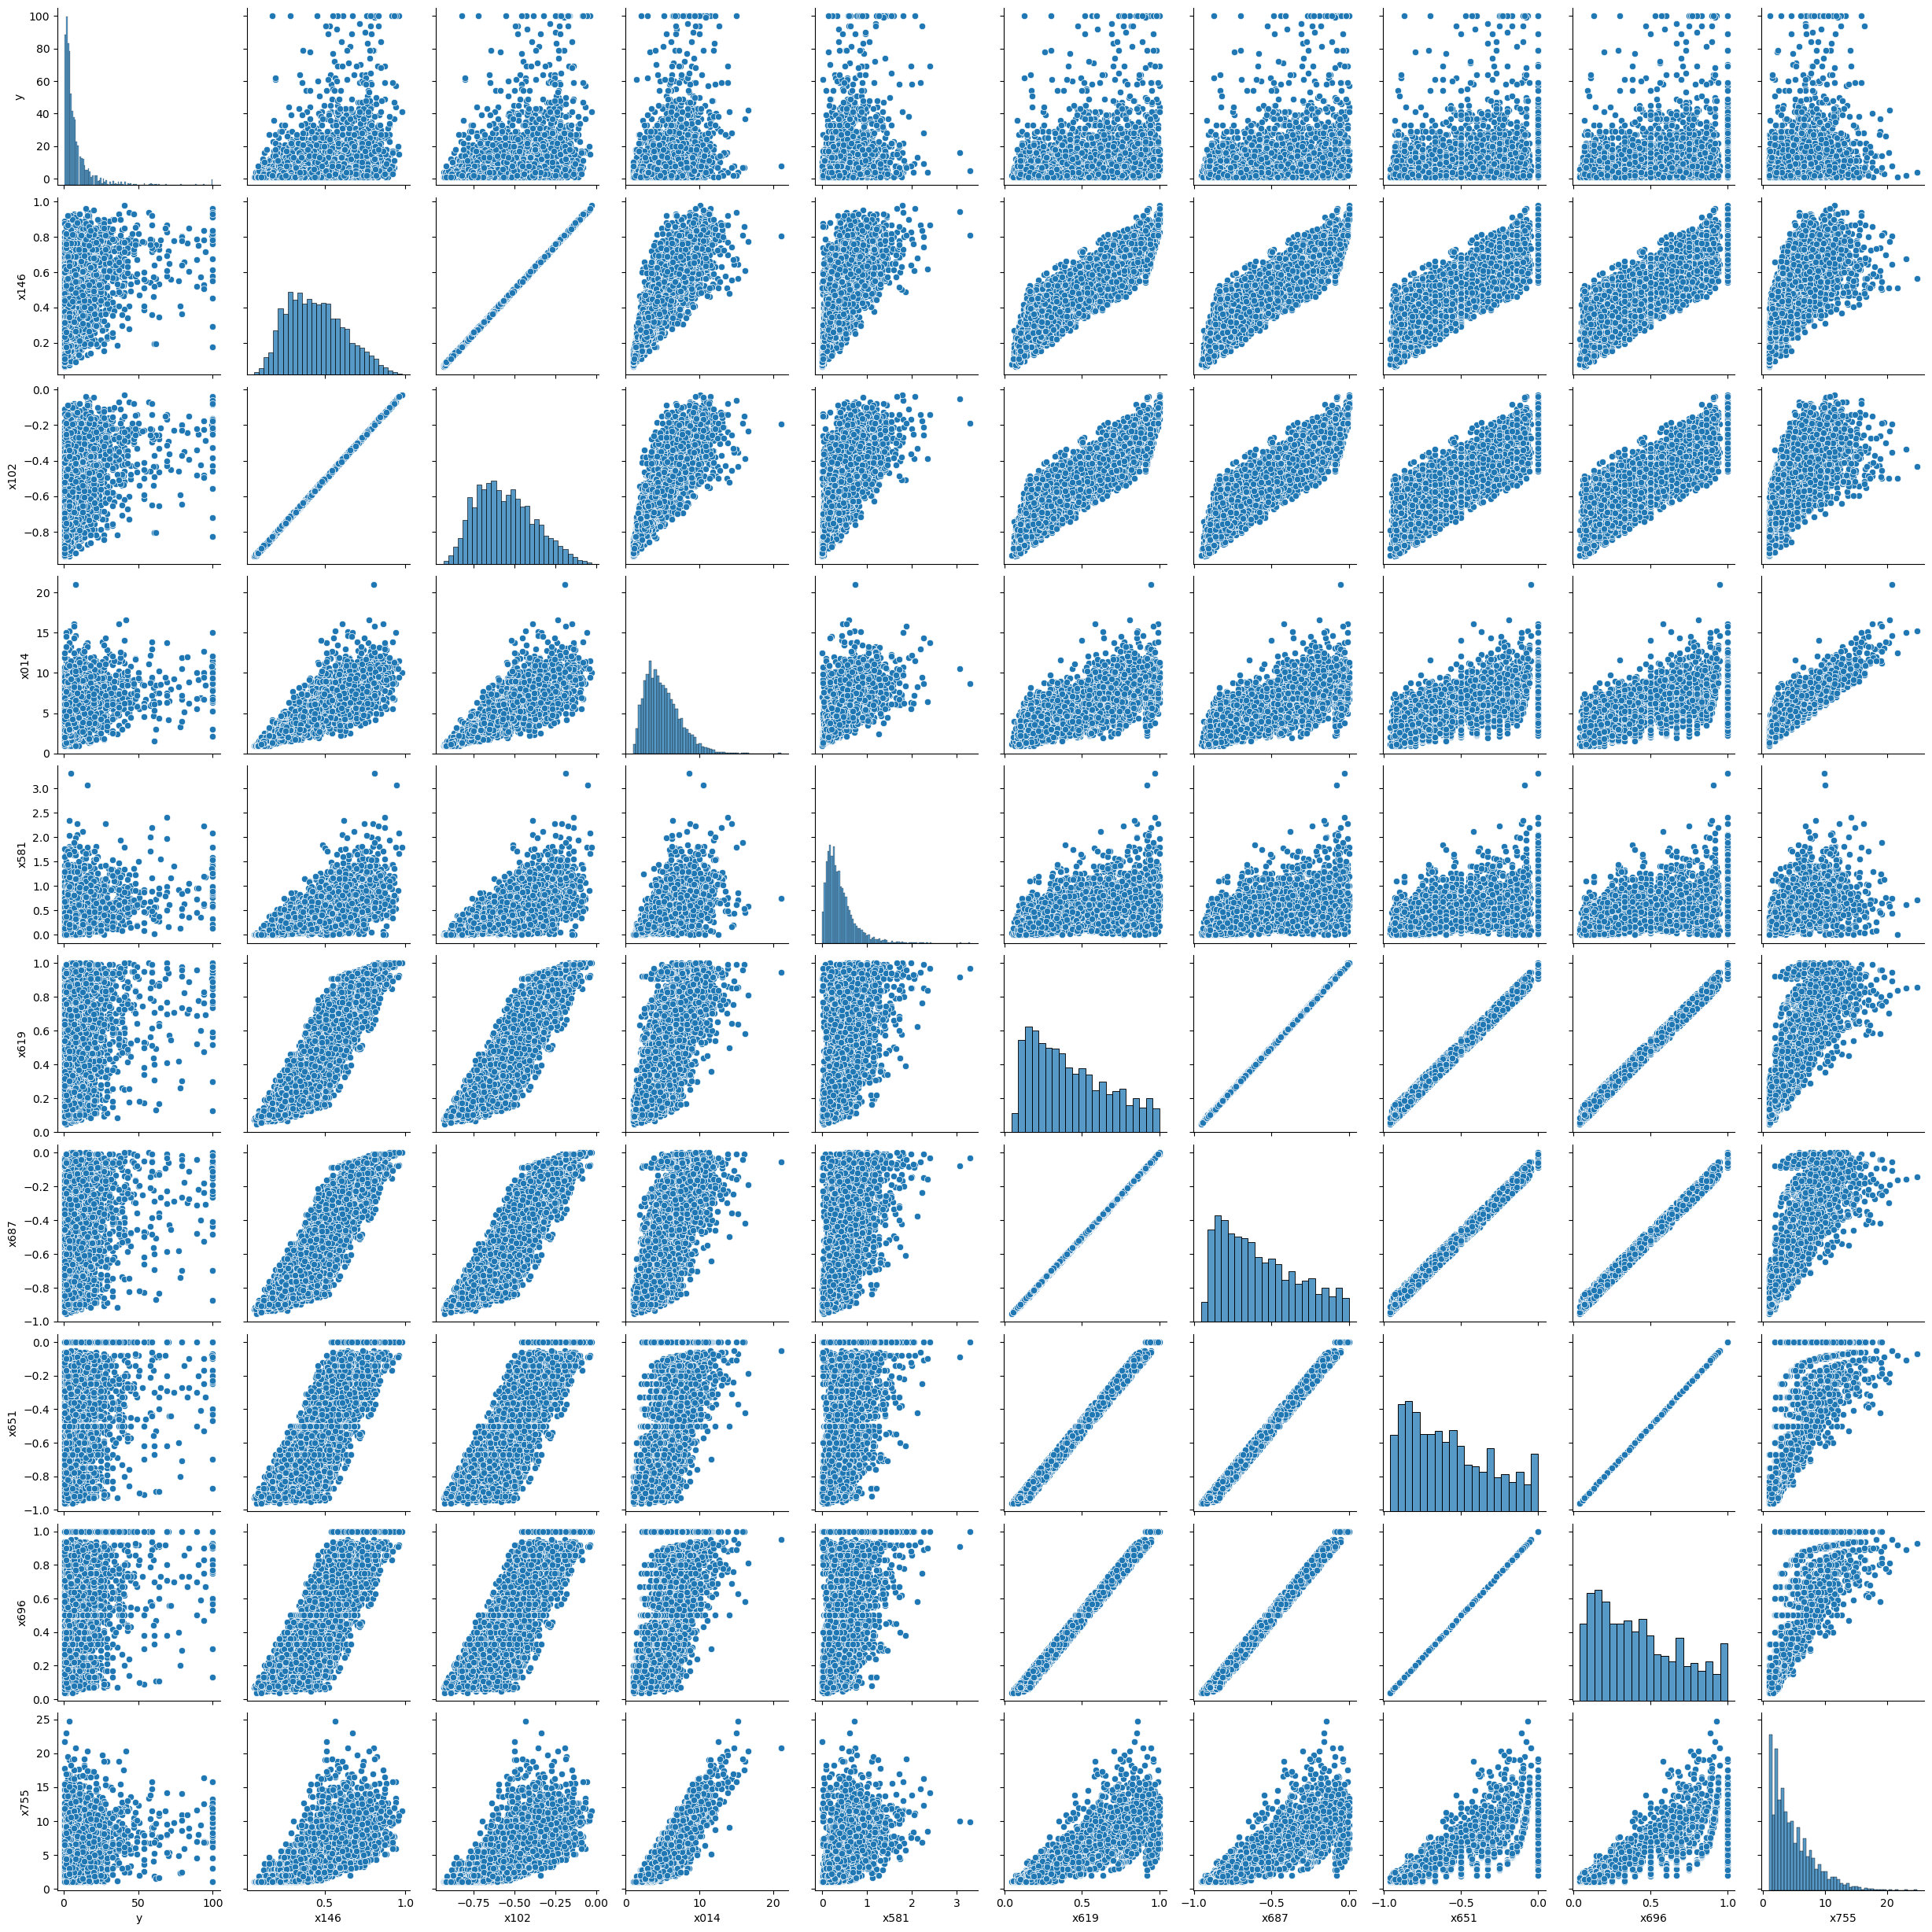

In [7]:
sns.pairplot(top_corr)

Observations: 
1. x102 and x146 are linearly corrrelated.
2. x619 is linearly correlated with 696, 651, 687
2. x687 is linearly correlated with x619, x651, x696
3. x651 is linearly correlated with x696, x687, 619
4. Many other linear correlations, some correlations also look exponential?

In [33]:
filtered.index

Index(['id', 'x001', 'x002', 'x003', 'x004', 'x005', 'x006', 'x007', 'x008',
       'x009',
       ...
       'x757', 'x758', 'x759', 'x760', 'x761', 'x762', 'x763', 'x764', 'x765',
       'y'],
      dtype='object', length=745)

In [68]:
filtered = corr_y[corr_y.notna()]

In [72]:
X = train[filtered.index].dropna()
y = X.y
X = X.drop('y', axis = 1)


## MARS

In [75]:
model = Earth(max_terms=500, max_degree=1) 
model.fit(X,y)

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(max_degree=1, max_terms=500)

### Cross-validation 

In [ ]:
# 5-fold cv
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
df = pd.DataFrame(columns = ['degree', 'MSE'])
row = 0
cv = KFold(n_splits = 5, shuffle = True, random_state = 1)
for d in degrees:
    # Create a MARS model
    model = Earth(max_terms = 500, max_degree = d)
    model.fit(X, y)
    # crossvalidate - use neg_mean_squared_error     
    cross_val = -cross_val_score(model, X, y, cv = cv, scoring = 'neg_mean_squared_error')
    mse = np.mean(cross_val)
    df.loc[row, 'degree'] = d
    df.loc[row, 'MSE'] = np.mean(cross_val)
    row += 1



/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]
/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`

/Users/ashleywitarsa/opt/anaconda3/lib/python3.8/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


## Decision Tree